In [27]:
import torch 
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
# Creating a dataset 
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, window_size):
        self.data = data 
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.window_size]
        y = self.data[idx + self.window_size]
        return x,y 

In [29]:
# prepare the dataloader
x = torch.linspace(0, 799, steps=800)
y = torch.sin(x * 2 * 3.1416 / 40)

# Split the data into training and testing 
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

# Create Dataloader for the first trainig set 
window_size = 40
train_dataset = TimeSeriesDataset(train_set, window_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TimeSeriesDataset(test_set, window_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [30]:
# Define the LSTM model 
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1, num_layers=1, batch_first=True):
        super().__init__()
        self.hidden_size = hidden_size     
        self.num_layers = num_layers 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, out_size)
      

    def forward(self, x):
        # Initialize the hidden cell state with zeros  
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propogate LSTM 
        out, (hn,cn) = self.lstm(x, (h0,c0))

        # Decode the hidden state of the last time step 
        out = self.linear(out[:,-1,:])

        return out

Epoch:  1 Loss: 0.20347431
Epoch:  2 Loss: 0.00123527
Epoch:  3 Loss: 0.00013973
Epoch:  4 Loss: 0.00001127
Epoch:  5 Loss: 0.00000773
Epoch:  6 Loss: 0.00000765
Epoch:  7 Loss: 0.00000692
Epoch:  8 Loss: 0.00000602
Epoch:  9 Loss: 0.00000431
Epoch: 10 Loss: 0.00000276
Loss on test prediction: 1.8888202248490416e-05


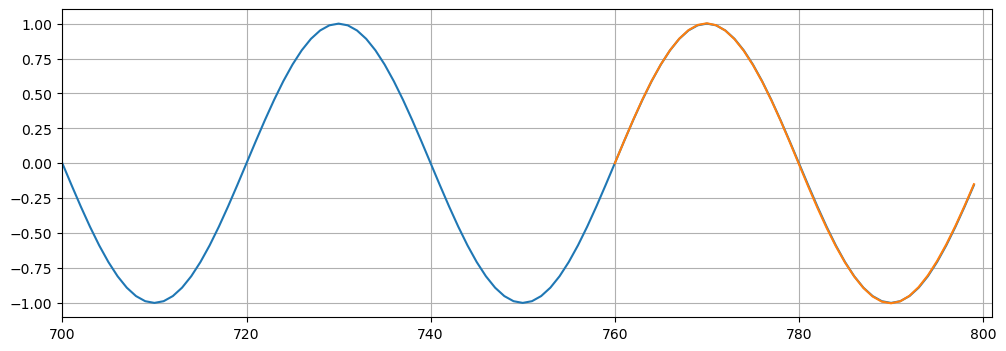

In [31]:
# Training the model 
torch.manual_seed(42)
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training the parameters 
epochs = 10
future = 40

for epoch in range(epochs):
    model.train()
    for seq_batch, y_train_batch in train_loader:
        optimizer.zero_grad()

        # Ensure that the input is of the shape (N,L,H_in)
        seq_batch = seq_batch.unsqueeze(-1) # (N,L,1)
        y_train_batch = y_train_batch.unsqueeze(-1) 

        y_pred_batch = model(seq_batch) 
        loss = criterion(y_pred_batch, y_train_batch)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')    
    
    # Make predictions for the future 
    model.eval()
    preds = y[-window_size:].tolist()
    for _ in range(future):
        seq = torch.FloatTensor(preds[-window_size:]).unsqueeze(0).unsqueeze(-1)
        with torch.no_grad():
            preds.append(model(seq).item())

loss = criterion(torch.tensor(preds[-window_size:]), y[760:]) 
print(f"Loss on test prediction: {loss}")

# Plot predictions
plt.figure(figsize=(12,4))
plt.xlim(700, 801)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(760, 800), preds[window_size:])
plt.show()

Epoch:  1 Loss: 0.00000582
Epoch:  2 Loss: 0.00000446
Epoch:  3 Loss: 0.00000411
Epoch:  4 Loss: 0.00000381
Epoch:  5 Loss: 0.00000368
Epoch:  6 Loss: 0.00000341
Epoch:  7 Loss: 0.00000320
Epoch:  8 Loss: 0.00000287
Epoch:  9 Loss: 0.00000652
Epoch: 10 Loss: 0.00040126

Duration: 2 seconds


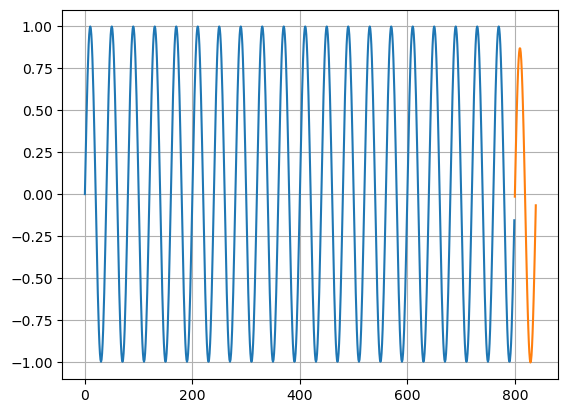

In [34]:
# Re-initialize data loader for all the data 
all_data = TimeSeriesDataset(y, window_size)
all_loader = torch.utils.data.DataLoader(all_data, batch_size=16, shuffle=False, drop_last=True)

# Retrain the model on the all dataset 
import time 
start_time = time.time()

for epoch in range(epochs):
    for seq_batch, y_train_batch in all_loader:
        optimizer.zero_grad()
        seq_batch = seq_batch.unsqueeze(-1) # (N,L,1)
        y_train_batch = y_train_batch.unsqueeze(-1)

        y_pred_batch = model(seq_batch)
        loss = criterion(y_pred_batch, y_train_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1:2} Loss: {loss.item():10.8f}")

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

preds = y[-window_size:].tolist()
for _ in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).unsqueeze(0).unsqueeze(-1) # (1,L,1)
    with torch.no_grad():
        preds.append(model(seq).item())

plt.figure()
plt.xlim()
plt.grid()
plt.plot(y.numpy())
plt.plot(range(800, 800+future), preds[window_size:])
plt.show()